# Example 8: Ionization and Thermal History

In this part of the notebook, we will show several different examples of how to evaluate the temperature and ionization histories using many of the different options available to `DarkHistory`. The function that solves the differential equations is `darkhistory.tla.get_history`, and the set of equations that is solved can be compactly written as follows:

$$ \dot{T}_m = \dot{T}_m^{(0)} + \dot{T}_m^{\text{inj}} + \dot{T}_m^\text{re} $$

$$ \dot{x}_\text{HII} = \dot{x}_\text{HII}^{(0)} + \dot{x}_\text{HII}^{\text{inj}} + \dot{x}_\text{HII}^\text{re} $$

$$ \dot{x}_\text{HeII} = \dot{x}_\text{HeII}^{(0)} + \dot{x}_\text{HeII}^{\text{inj}} + \dot{x}_\text{HeII}^\text{re} $$

with each of the terms defined in the paper.

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file('matplotlibrc')


import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.history.tla as tla

## Standard Ionization and Temperature Histories with Helium

The most basic use of `get_history` is to obtain the standard ionization and temperature histories with no exotic energy injection sources or reionization. In the simplest approximation, we can neglect helium and simply evaluate the following equations:

$$ \dot{T}_m = \dot{T}_m^{(0)}, \qquad \dot{x}_\text{HII} = \dot{x}_\text{HII}^{(0)}. $$

First, we initialize the redshift abscissa. This must be defined in decreasing redshift. Note that the transfer functions used in calculating $f_c(z)$ only span a redshift range of $4 \leq 1+z \leq 3000$. In this example, we solve the TLA from $1+z = 3000$ to $1+z = 1$. 

First, we define a redshift vector at which we would like to find the solution. The vector must be stored in *decreasing* redshift order, and should always be defined as $1+z$. 

In [4]:
rs_vec = np.flipud(np.arange(1., 3000., 0.1))

Now, we call the solver. If we simply pass the redshift abscissa to the function with no further options, the solution will not have any source of reionization, and helium is ignored. The initial conditions can be manually passed to the solver through the keyword argument `init_cond`, but not initializing it will result in the solver starting at the standard ionization and temperature values at `rs_vec[0]`. 

In [5]:
soln_no_He = tla.get_history(rs_vec)

If we would like to also solve for the helium ionization fraction, i.e. solve the system

$$ \dot{T}_m = \dot{T}_m^{(0)}, \qquad \dot{x}_\text{HII} = \dot{x}_\text{HII}^{(0)}, \qquad \dot{x}_\text{HeII} = \dot{x}_\text{HeII}^{(0)}, $$

we will need to set the `helium_TLA` flag to `True`. Here is how we call the function:


In [6]:
soln_with_He = tla.get_history(rs_vec, helium_TLA=True)

The solution is returned as an array with dimensions `(rs_vec.size, 4)`. Each column corresponds to the solution for ($T_m$ in eV, $x_\mathrm{HII}$, $x_\mathrm{HeII}$, $x_\mathrm{HeIII}$). Let's plot temperature in K, and the ionization fraction $x_e = x_\mathrm{HII} + x_\mathrm{HeII}$ as a function of redshift $1+z$. We will plot both solutions for comparison.

[1400.0, 3000.0, 0.95, 1.13]

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


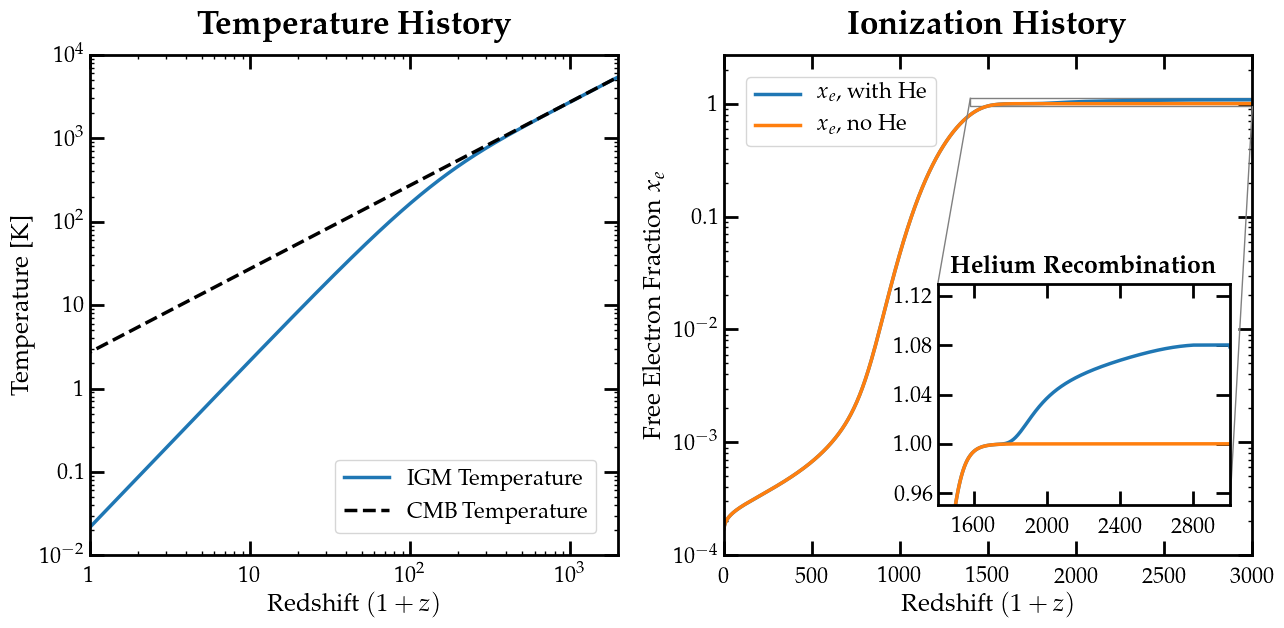

In [7]:
Tm = soln_no_He[:,0]/phys.kB

xe_no_He   = soln_no_He[:,1]
# The other columns with xHeII and xHeIII are negligible.
xe_with_He = soln_with_He[:,1] + soln_with_He[:,2]
#The last column with xHeIII is negligible


fig_He = plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

plt_T_IGM, = plt.plot(rs_vec, Tm, label='IGM Temperature')
# Plot the CMB temperature for comparison, using the function phys.TCMB
plt_T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[plt_T_IGM, plt_T_CMB], loc=4)


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([1, 2e3, 1e-2, 1e4])

ax = plt.subplot(1,2,2)

plt_He,    = plt.plot(rs_vec, xe_with_He, label=r'$x_e$, with He')
plt_no_He, = plt.plot(rs_vec, xe_no_He,   label=r'$x_e$, no He')

plt.legend(handles=[plt_He, plt_no_He], loc=2)

# ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Free Electron Fraction $x_e$')
plt.axis([1, 3e3, 1e-4, 2.7])

from matplotlib.transforms import blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

transform = blended_transform_factory(fig_He.transFigure, ax.transAxes)
axins = inset_axes(ax,  width="22%", height="50%",
                    bbox_to_anchor=(0, 0.1, 0.885, 0.885),
                    bbox_transform=transform, loc=4, borderpad=0)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.plot(rs_vec, xe_with_He)
plt.plot(rs_vec, xe_no_He)
plt.title(r'\bf{Helium Recombination}', fontsize=18, y = 0.95)
plt.yticks([0.96, 1., 1.04, 1.08, 1.12])
plt.xticks([1600, 2000, 2400, 2800])
plt.axis([1.4e3, 3e3, 0.95, 1.13])

A few technical details to note.  Ionization levels are solved numerically using the variable 

$$\zeta_i \equiv \text{arctanh} \left[\frac{2}{\chi_i}\left(x_i - \frac{\chi_i}{2} \right) \right]$$

for $i = $ HII, HeII and HeIII, with $\chi_i=1$ for HII and $\chi_i = \mathcal{F}_\text{He}$ for HeII and HeIII. This guarantees that the ionization fraction $x_e$ is bounded between 0 and 1. As a result, it is common to find that $x_i$ values may not be completely zero when they are expected to be, but instead have some small, non-zero value. This is simply a negligible numerical error that can be ignored. Ionization levels below $10^{-12}$ should not be regarded as accurate. 

## Reionization

### Default Model

The solver can also accept a reionization model. A default reionization model is included with `DarkHistory`. This model combines the fiducial photoionization and photoheating rates provided in [[1]](#cite_rates1)<cite data-cite="6232408/MJ7LY7BF"></cite> with rates for collisional ionization, collisional excitation, recombination cooling and bremsstrahlung cooling given in [[2]](#cite_rates2)<cite data-cite="6232408/4FF4XZAM"></cite>, in order to obtain the ionization/temperature change during reionization (for more details, refer to the paper). The photoionization and photoheating data for the model are stored in `darkhistory.history.reionization`.

Reionization models must come with a redshift at which they turn on, $1+z_\text{re}$ (the default model has $1+z_\text{re} = 16.1$, and is set automatically by the code). Prior to reionization, the solver will integrate the usual set of equations without reionization:

$$ \dot{T}_m = \dot{T}_m^{(0)}, \qquad \dot{x}_\text{HII} = \dot{x}_\text{HII}^{(0)}, \qquad \dot{x}_\text{HeII} = \dot{x}_\text{HeII}^{(0)}, $$

Once reionization starts, it will instead integrate

$$ \dot{T}_m = \dot{T}_m^{(0)} + \dot{T}_m^\text{re}, \qquad \dot{x}_\text{HII} = \dot{x}_\text{HII}^\text{re}, \qquad \dot{x}_\text{HeII} = \dot{x}_\text{HeII}^\text{re}, $$

To obtain the temperature/ionization history with the default reionization model, simply specify `reion_switch = True`. In the default case, the solver knows when to switch to the reionization equations. For other models, the user must also specify the `reion_rs` flag. In this example, we will also solve for helium as well, which is the self-consistent thing to do here.

In [9]:
soln_default_reion = tla.get_history(rs_vec, helium_TLA=True, reion_switch=True, mxstep=0)

And now plot the results. These results should be compared to Fig. 6 of [[1]](#cite_rates1)<cite data-cite="6232408/MJ7LY7BF"></cite> and are in good agreement.

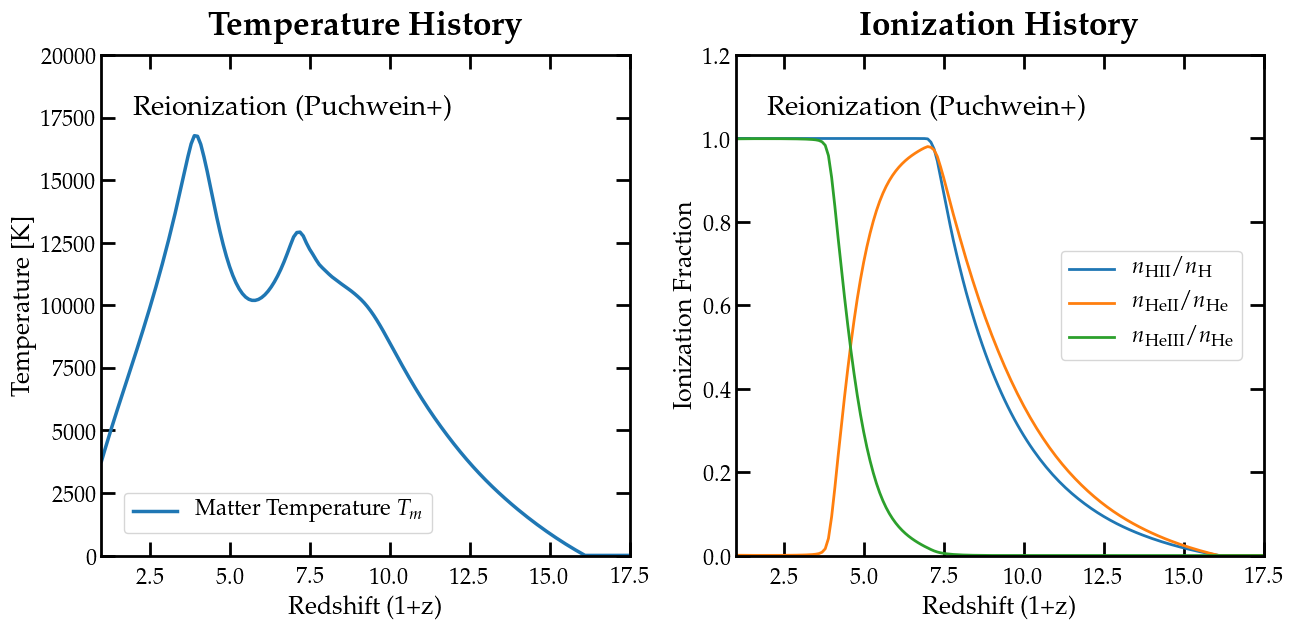

In [10]:
fig_reion=plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

plt_Tm_reion, = plt.plot(rs_vec, soln_default_reion[:,0]/phys.kB, label=r'Matter Temperature $T_m$')

# Text
plt.text(0.06, 0.88, 'Reionization (Puchwein+)', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plt_Tm_reion], loc=3)

plt.title(r'\bf{Temperature History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel(r'Temperature [K]')
plt.axis([1, 17.5, 0, 20000])

ax = plt.subplot(1,2,2)

plt_xHII, = plt.plot(rs_vec, soln_default_reion[:,1], linewidth=2, label=r'$n_\mathrm{HII}/n_\mathrm{H}$')
plt_xHeII, = plt.plot(rs_vec, soln_default_reion[:,2]/phys.chi, linewidth=2, label=r'$n_\mathrm{HeII}/n_\mathrm{He}$')
# The solution is stored as nHeII/nH, so it needs to be converted to nHeII/nHe. 
plt_xHeIII, = plt.plot(rs_vec, soln_default_reion[:,3]/phys.chi, linewidth=2, label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$')
# Same for HeIII. 

# Text
plt.text(0.06, 0.88, 'Reionization (Puchwein+)', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plt_xHII, plt_xHeII, plt_xHeIII], loc=5)

plt.title(r'\bf{Ionization History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Ionization Fraction')
plt.axis([1, 17.5, 0, 1.2])

### User-Defined Model

The user may enter their own photoionization and photoheating rates into the TLA solver. This is done by defining two tuples of functions, each containing the photoionization and photoheating rates respectively of HI, HeI and HeII. Here, we define functions `photoion_rate` and `photoheat_rate` to return these tuples, given some new photoionization and photoheating rates. In this example, we use the rates from [[3]](#cite_rates3)<cite data-cite="6232408/QRY4E9Y7"></cite>.

In [ ]:
def photoion_rate():
    
    rs_vec = 1. + np.array([
        0.00, 0.05, 0.10, 0.16, 0.21, 0.27, 0.33, 0.40, 0.47,
        0.54, 0.62, 0.69, 0.78, 0.87, 0.96, 1.05, 1.15, 1.26, 
        1.37, 1.49, 1.61, 1.74, 1.87, 2.01, 2.16, 2.32, 2.48,
        2.65, 2.83, 3.02, 3.21, 3.42, 3.64, 3.87, 4.11, 4.36,
        4.62, 4.89, 5.18, 5.49, 5.81, 6.14, 6.49, 6.86, 7.25,
        7.65, 8.07, 8.52, 8.99, 9.48, 9.99, 10.50, 11.10, 11.70,
        12.30, 13.00, 13.70, 14.40, 15.10
    ])
    
    rate_vec_HI = np.array([
        22.8, 28.4, 35.4, 44.0, 54.6, 67.4, 83.1, 102, 125,
        152, 185, 223, 267, 318, 376, 440, 510, 585, 660, 732, 
        799, 859, 909, 944, 963, 965, 950, 919, 875, 822, 765, 
        705, 647, 594, 546, 504, 469, 441, 412, 360, 293, 230,
        175, 129, 92.8, 65.5, 45.6, 31.2, 21.2, 14.3, 9.59, 
        6.40, 4.27, 2.92, 1.73, 1.02, 0.592, 0.341, 0.194
    ]) * 1e-15
    
    rate_vec_HeI = np.array([
        12.4, 15.7, 19.6, 24.6, 30.7, 38.3, 47.5, 58.7, 72.2,
        88.4, 108, 130, 157, 187, 222, 261, 302, 346, 391, 
        434, 474, 509, 538, 557, 567, 566, 555, 535, 508,
        476, 441, 406, 372, 341, 314, 291, 271, 253, 237, 214,
        184, 154, 125, 99.2, 76.1, 56.8, 41.4, 29.6, 20.7, 
        14.4, 9.82, 6.67, 4.53, 3.24, 2.02, 1.23, 0.746, 0.446,
        0.262
    ]) * 1e-15
    
    rate_vec_HeII = np.array([
        0.555, 0.676, 0.823, 1.00, 1.22, 1.48, 1.80, 2.18,
        2.63, 3.17, 3.80, 4.54, 5.38, 6.33, 7.38, 8.52, 
        9.70, 10.9, 11.9, 12.7, 13.2, 13.4, 13.3, 12.8, 
        11.9, 10.6, 9.04, 7.22, 5.30, 3.51, 2.08, 1.14,
        0.591, 0.302, 0.152, 0.0760, 0.0375, 0.0182,
        0.00857, 0.00323, 0.00117, 4.42e-4, 1.73e-4, 
        7.01e-5, 2.92e-5, 1.25e-5, 5.67e-6, 2.74e-6, 1.44e-6,
        8.19e-7, 4.99e-7, 3.25e-7, 2.12e-7, 1.43e-7, 9.84e-8,
        6.81e-8, 4.73e-8, 3.30e-8, 1.92e-8
    ]) * 1e-15

    def ion_rate_HI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HI))
        return 10**log10_rate
    
    def ion_rate_HeI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeI))
        return 10**log10_rate
    
    def ion_rate_HeII(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeII))
        return 10**log10_rate

    return (ion_rate_HI, ion_rate_HeI, ion_rate_HeII)

def photoheat_rate():
    
    rs_vec = 1. + np.array([
        0.00, 0.05, 0.10, 0.16, 0.21, 0.27, 0.33, 0.40, 0.47,
        0.54, 0.62, 0.69, 0.78, 0.87, 0.96, 1.05, 1.15, 1.26, 
        1.37, 1.49, 1.61, 1.74, 1.87, 2.01, 2.16, 2.32, 2.48,
        2.65, 2.83, 3.02, 3.21, 3.42, 3.64, 3.87, 4.11, 4.36,
        4.62, 4.89, 5.18, 5.49, 5.81, 6.14, 6.49, 6.86, 7.25,
        7.65, 8.07, 8.52, 8.99, 9.48, 9.99, 10.50, 11.10, 11.70,
        12.30, 13.00, 13.70, 14.40, 15.10
    ])
    
    rate_vec_HI = np.array([
        8.89, 11.1, 13.9, 17.3, 21.5, 26.6, 32.9, 40.5, 49.6, 
        60.5, 73.4, 88.5, 106, 126, 149, 175, 203, 232, 262,
        290, 317, 341, 360, 374, 381, 382, 375, 363, 346, 325,
        302, 279, 257, 236, 218, 202, 189, 178, 167, 148, 123,
        98.9, 77.1, 58.3, 43.0, 31.0, 21.9, 15.3, 10.5, 7.13, 
        4.81, 3.23, 2.17, 1.51, 0.915, 0.546, 0.323, 0.189, 0.110
    ]) * 1e-14
    
    rate_vec_HeI = np.array([
        11.2, 14.0, 17.4, 21.6, 26.7, 33.1, 40.8, 50.2, 61.5,
        75.1, 91.1, 110, 132, 157, 186, 217, 251, 287, 323, 
        357, 387, 413, 432, 444, 446, 438, 422, 398, 368, 336,
        304, 274, 249, 227, 209, 194, 181, 170, 160, 146, 130, 
        112, 95.2, 78.3, 62.5, 48.3, 36.3, 26.6, 19.1, 13.4, 
        9.27, 6.36, 4.35, 3.14, 1.98, 1.22, 0.749, 0.455, 0.270
    ])* 1e-14

    rate_vec_HeII = np.array([
        1.14, 1.38, 1.68, 2.03, 2.45, 2.96, 3.57, 4.29, 5.14,
        6.15, 7.32, 8.67, 10.2, 11.9, 13.9, 15.9, 18.1, 20.2,
        22.1, 23.7, 24.7, 25.3, 25.2, 24.4, 22.9, 20.7, 17.8,
        14.5, 11.1, 7.75, 4.97, 2.96, 1.68, 0.925, 0.501, 0.267,
        0.141, 0.0727, 0.0365, 0.0156, 0.00624, 0.00269, 0.00128,
        6.74e-4, 3.88e-4, 2.40e-4, 1.55e-4, 1.03e-4, 6.98e-5, 
        4.76e-5, 3.26e-5, 2.24e-5, 1.53e-5, 1.06e-5, 7.52e-6,
        5.31e-6, 3.73e-6, 2.57e-6, 1.54e-6
    ]) * 1e-14

    def heat_rate_HI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HI))
        return 10**log10_rate
    
    def heat_rate_HeI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeI))
        return 10**log10_rate
    
    def heat_rate_HeII(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeII))
        return 10**log10_rate

    return (heat_rate_HI, heat_rate_HeI, heat_rate_HeII)



Now we call the solver. In addition to setting `reion_switch=True`, we must also specify the redshift `reion_rs` at which reionization effects start, as well as the two tuples for `photoion_rate_func` and `photoheat_rate_func` respectively.

In [ ]:
soln_user_reion = tla.get_history(
    rs_vec, helium_TLA=True, reion_switch=True, 
    reion_rs = 16.1, photoion_rate_func=photoion_rate(), photoheat_rate_func=photoheat_rate()
)

Plot the results, and compare them to the our default model. Again, this shows good agreement with Fig. 6 of [[1]](#cite_rates1)<cite data-cite="6232408/MJ7LY7BF"></cite>.

In [ ]:
plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

plt_Tm_Puchwein, = plt.plot(rs_vec, soln_default_reion[:,0]/phys.kB, ':', label='Matter Temperature, Puchwein+')
plt_Tm_Haardt, = plt.plot(rs_vec, soln_user_reion[:,0]/phys.kB, label='Matter Temperature, Haardt+')

plt.legend(handles=[plt_Tm_Puchwein, plt_Tm_Haardt])


plt.title(r'\bf{Temperature History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Temperature [K]')
plt.axis([1, 17.5, 0, 20000])

ax = plt.subplot(1,2,2)

plt_xHII_Puchwein, = plt.plot(
    rs_vec, soln_default_reion[:,1], ':',
    label=r'$n_\mathrm{HII}/n_\mathrm{H}$, Puchwein+'
)
plt_xHII_Haardt, = plt.plot(
    rs_vec, soln_user_reion[:,1],
    label=r'$n_\mathrm{HII}/n_\mathrm{H}$, Haardt+'
)
plt_xHeIII_Puchwein, = plt.plot(
    rs_vec, soln_default_reion[:,3]/phys.chi, ':',
    label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$, Puchwein+'
)
plt_xHeIII_Haardt, = plt.plot(
    rs_vec, soln_user_reion[:,3]/phys.chi, 
    label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$, Haardt+'
)

plt.legend(handles=[plt_xHII_Puchwein, plt_xHII_Haardt, plt_xHeIII_Puchwein, plt_xHeIII_Haardt], loc=1)

plt.title(r'\bf{Ionization History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Ionization Fraction')
plt.axis([1, 17.5, 0, 1.55])

### Fixed Ionization History

A less self-consistent way to model reionization is to fix the ionization history once reionization begins. When combined with exotic sources of energy injection, this treatment will not account for additional ionization from the energy injection, while the energy deposition into heating will be calculated based only on the fixed ionization history that has been specified. However, if we expect the additional ionization from energy injection to only be a small perturbation on top of reionization, this may be a good approximation.

We will now take the standard $\text{tanh}$ model that is used in [[4]](#cite_tanh)<cite data-cite="6232408/XNS48NT3"></cite>, with

$$ x_e = \frac{1+\mathcal{F}_\text{He}}{2} \left[1 + \tanh \left( \frac{ \eta - \eta_\text{re}}{\delta \eta} \right) \right] . $$

$\eta \equiv (1+z)^{3/2}$, and we take $\delta \eta = 0.75 (1+z)^{1/2}$. We choose $z_\text{re} = 8.8$ and $\delta \eta = 1.5(1+z)^{1/2} \times 0.7$.

For simplicity, `DarkHistory` always assumes $n_\text{HII} = n_\text{HeII}$, a standard assumption in many reionization models. Changing this assumption would only require a relatively straightforward but messy modification to `history.tla.get_history`. We do not implement the full reionization of HeII to HeIII.

We first define the model as a function that takes in redshift $1+z$ and returns the $x_e$ value:

In [ ]:
# Define the standard ionization history as an interpolation function for convenience. 

def xe_reion_func(rs):
    # Parameters of the model.
    
    f = 1. + phys.chi
    delta_z = 0.7
    delta_eta = 1.5*rs**0.5*delta_z
    z_re = 8.8
    eta = rs**(3/2)
    eta_re = (1 + z_re)**(3/2)
    
    reion_model_xe = (f/2)*(1 + np.tanh((eta_re - eta)/delta_eta))
    
    return reion_model_xe

Then, we pass it to the solver through the flag `xe_reion_func`. Remember to also specify `reion_rs`, which we take to be $1+z_\text{re} = 10$ here. In order to try to give smooth solutions, the switchover point into the reionization model is *not* given strictly by `reion_rs`, but by the largest redshift where `xe_reion_func` first returns a value of $x_e$ that exceeds the solution without reionization.

In [ ]:
soln_fixed_reion = tla.get_history(
    rs_vec, reion_switch=True, helium_TLA=True,
    reion_rs = 13., xe_reion_func = xe_reion_func
)

And the plot! Note that this treatment completely neglects the photoheating contribution to the IGM temperature, leading to a very cold IGM compared to the earlier, more complete reionization models. This may however still be useful for setting lower bounds. 

In [ ]:
plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

plt_TIGM, = plt.plot(rs_vec, soln_fixed_reion[:,0]/phys.kB, label=r'Matter Temperature $T_m$')

# Text
plt.text(0.06, 0.88, 'Reionization (tanh)', fontsize=20, transform=ax.transAxes) 

plt.axis([1, 18.5, 1, 12.5])
plt.title(r'\bf{Temperature History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Temperature [K]')

leg=plt.legend(handles=[plt_TIGM], loc=4)

ax = plt.subplot(1,2,2)

plt_xHII,  = plt.plot(rs_vec, soln_fixed_reion[:,1], label=r'$n_\mathrm{HII}/n_\mathrm{H}$')
plt_xHeII, = plt.plot(rs_vec, soln_fixed_reion[:,2], label=r'$n_\mathrm{HeII}/n_\mathrm{H}$')
plt_xe,    = plt.plot(rs_vec, soln_fixed_reion[:,1] + soln_fixed_reion[:,2], label=r'$n_e/n_\mathrm{H}$')

# Text
plt.text(0.06, 0.88, 'Reionization (tanh)', fontsize=20, transform=ax.transAxes) 

leg=plt.legend(handles=[plt_xHII, plt_xHeII, plt_xe], loc=5)

plt.axis([1, 18.5, -0.1, 1.4])

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Ionization Fraction')

## Reionization + Dark Matter

### Dark Matter

Now, we will introduce dark matter into the TLA equations. We introduce a dark matter species with mass $m_\chi = $ 100 MeV that decays with some (long) lifetime into an $e^+e^-$ pair. The energy injection rate is:

$$ \left( \frac{dE}{dV \, dt} \right)_{\text{inj.}} = \frac{\rho_{\text{DM},0}}{\tau} (1 + z)^3  $$

where $\tau$ is the lifetime, and $\rho_{\text{DM},0}$ is the dark matter density today. 

`get_history` requires four inputs in order to solve the TLA with DM injection: three functions that describe $f_c(z)$ as a function of redshift, $x_\mathrm{HI}$, $x_\mathrm{HeI}$ and $x_\mathrm{HeII}$, with $c$ indexing hydrogen ionization, hydrogen excitation and collisional heating, as well as the dark matter energy injection rate.

In this example, we will simply use the $f_c(z)$ computed in <cite data-cite="6232408/S55R7ACJ"></cite>, which assumes the default RECFAST ionization history and is therefore only dependent on redshift. *If the user only intends to use these $f_c(z)$ values, then `get_history` alone is sufficient for all purposes*. The rest of `DarkHistory` is focused on correctly computing $f_c(z,\mathbf{x})$ to ensure that backreaction is taken into account.

First, let's import the $f_c(z)$ functions.

In [13]:
# Import f's

from scipy.interpolate import interp2d

# Load the raw data. 
fz_elec_decay = np.loadtxt('/Users/hongwan/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

# Processing the table. 

# Log[10, 1+z].
log10rs  = fz_elec_decay[0:70, 1]
# Energy of the particle injected. Note that for our model, it would be mDM/2 - phys.me . 
log10eng = fz_elec_decay[0:2800:70, 0] 

# The table of Log[10, f_c], dimensions energy x redshift. 
log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

In order to pass these $f_c(z)$ values into `get_history`, we need to recast them as functions, which get called internally. These can be interpolation functions taking $(1+z, x_\text{HI}, x_\text{HeI}, x_\text{HeII})$ as arguments. 

In [51]:
# Define the mass of the dark matter.
mDM = 1e12

# Define interpolation functions for each of the relevant channels. 
# Note that the raw data stores f_c(z) as a function of 
# the energy of the decay electron, which is mDM/2 - phys.me .

def f_H_ion(rs, xHI, xHeI, xHeII):
    
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_ion']) 
    return 10**interp_func(np.log10(mDM/2 - phys.me), np.log10(rs))

def f_H_exc(rs, xHI, xHeI, xHeII):
    
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_exc'])
    return 10**interp_func(np.log10(mDM/2 - phys.me), np.log10(rs))

def f_heating(rs, xHI, xHeI, xHeII):
    
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['heating'])
    return 10**interp_func(np.log10(mDM/2 - phys.me), np.log10(rs))

The user also needs to specify the energy injection rate for this. This is also a function of just $1+z$. Note that there is a built-in function called `physics.inj_rate` that is useful for this. Here, we choose a rate for 100 MeV decaying dark matter into $e^+e^-$ that is just consistent with the CMB constraints, as shown in <cite data-cite="6232408/VKMX8MFJ"></cite>. 

In [52]:
# The user may also choose to use `physics.inj_rate` to construct this function.
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 3e25
    return phys.rho_DM*rs**3/tau

With these functions defined, we can now call the solver in the manner shown below (we turn off helium for this example). With dark matter, the redshift cannot go below $1+z = 4$, where the `DarkHistory` calculation of $f_c(z)$ stops.

In [55]:
%autoreload
rs_vec_DM = np.flipud(np.arange(6, 3000., 0.1))

soln_DM_bak = tla.get_history(
    rs_vec_DM, 
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, 
    f_heating=f_heating, injection_rate=dm_injection_rate,
    reion_switch=False,
    helium_TLA=False
)

soln_DM = tla.get_history(
    rs_vec_DM, baseline_f = True, inj_particle='elec',
    DM_process = 'decay',
    mDM = 1e12, lifetime = 3e25,
    reion_switch=False,
    helium_TLA=False
)

And this is the outcome of the computation. We will compare these results with the standard solution with no dark matter energy injection or reionization, which is accessible through `physics.xH_std` and `physics.Tm_std`. 

[4, 3000.0, 1e-05, 3]

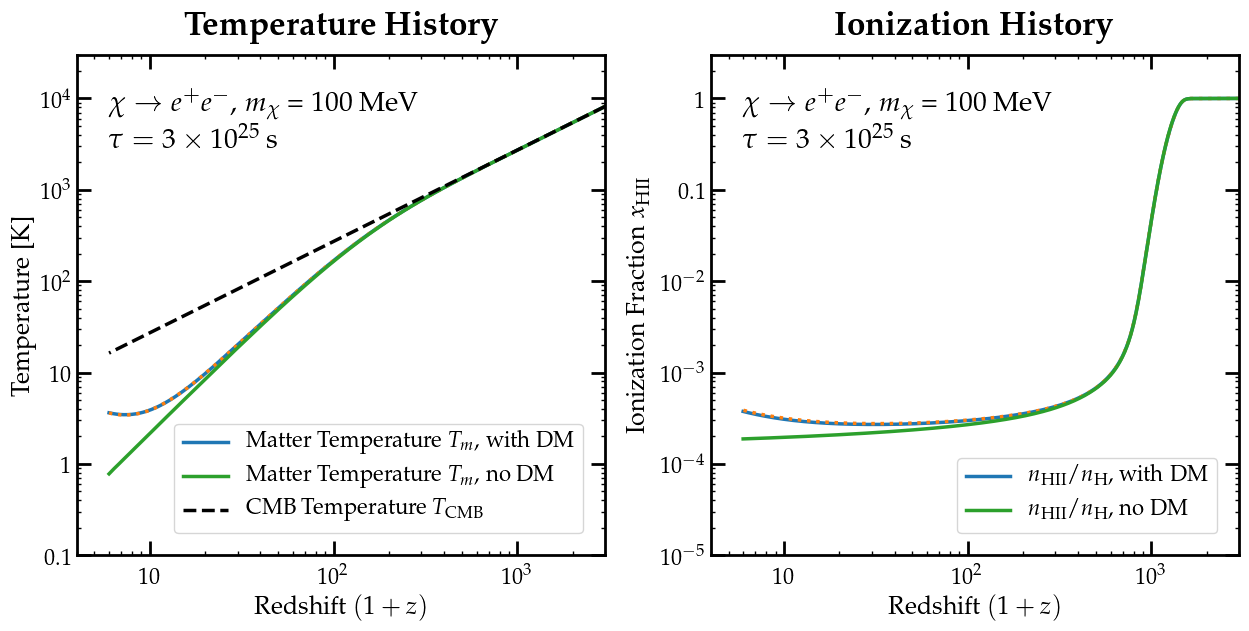

In [56]:
Tm_DM = soln_DM[:,0]/phys.kB
xHII_DM = soln_DM[:,1]

Tm_DM_bak = soln_DM_bak[:,0]/phys.kB
xHII_DM_bak = soln_DM_bak[:,1]

fig_DM = plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

plt_T_DM,  = plt.plot(rs_vec_DM, Tm_DM, label=r'Matter Temperature $T_m$, with DM')
plt.plot(rs_vec_DM, Tm_DM_bak, ':', label=r'Matter Temperature $T_m$, with DM OLD')
plt_T_std, = plt.plot(rs_vec_DM, phys.Tm_std(rs_vec_DM)/phys.kB, label=r'Matter Temperature $T_m$, no DM') 
# Plot the CMB temperature for comparison, using the function phys.TCMB
plt_T_CMB, = plt.plot(rs_vec_DM, phys.TCMB(rs_vec_DM)/phys.kB, 'k--', label=r'CMB Temperature $T_\mathrm{CMB}$')

# Text
plt.text(0.06, 0.88, r'$\chi \to e^+e^-$, $m_\chi$ = 100 MeV', fontsize=20, transform=ax.transAxes) 
plt.text(0.06, 0.82, r'$\tau = 3 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)

ax.set_xscale('log')
ax.set_yscale('log')

leg = plt.legend(handles=[plt_T_DM, plt_T_std, plt_T_CMB], loc=4)


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([4, 3e3, 1e-1, 3e4])

ax = plt.subplot(1,2,2)

plt_xHII_DM,    = plt.plot(rs_vec_DM, xHII_DM, label=r'$n_\mathrm{HII}/n_\mathrm{H}$, with DM')
plt.plot(rs_vec_DM, xHII_DM_bak, ':', label=r'xe OLD')
plt_xHII_std,   = plt.plot(rs_vec_DM, phys.xHII_std(rs_vec_DM), label=r'$n_\mathrm{HII}/n_\mathrm{H}$, no DM')

# Text
plt.text(0.06, 0.88, r'$\chi \to e^+e^-$, $m_\chi$ = 100 MeV', fontsize=20, transform=ax.transAxes) 
plt.text(0.06, 0.82, r'$\tau = 3 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)

leg = plt.legend(handles=[plt_xHII_DM, plt_xHII_std], loc=4)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Ionization Fraction $x_\mathrm{HII}$')
plt.axis([4, 3e3, 1e-5, 3])


### Dark Matter and Reionization

Now it's time to combine dark matter energy injection with reionization! This is easily done by turning `reion_switch` to `True` to use the default reionization model. Again, for comparison, we provide the solution without and with backreaction turned on. 

There are two ways to obtain the histories without any backreaction. The user can call `main.evolve` with `backreaction = False` or, if the only information they require is the matter temperature and ionization levels only, they can directly call `tla.get_history` and provide the $f_c(z)$ values for electron/positrons and photons calculated without backreaction. These $f_c(z)$ values are provided by DarkHistory in the downloaded data folder. `tla.get_history` is also much faster, since it does not calculate spectra. 

In [ ]:
soln_DM_reion = tla.get_history(
    rs_vec_DM, 
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, 
    f_heating=f_heating, dm_injection_rate=dm_injection_rate,
    reion_switch=True,
    helium_TLA=True
)

To calculate the result with backreaction, `main.evolve` must be used, with `backreaction = True`. For the case of $\chi \to e^+e^-$ without any electroweak corrections, `primary` must be set to `elec_delta`. Since we are importing `main` for the first time, the transfer functions will be loaded. We'll compute both the results without reionization `soln_DM_BR` and `soln_DM_reion_BR`. Reionization is turned on by setting `reion_switch = True`, and uses the default reionization model. `helium_TLA` should be set to `True` as well for consistency.

Without reionization, `coarsen_factor = 32` is a reasonable choice, since the temperature changes slowly with redshift. Coarsening with reionization is not advised, due to rapid changes in temperature that should be integrated over small step sizes. 

In [ ]:
%autoreload 2

import main

soln_DM_BR = main.evolve(
    DM_process='decay', mDM=1e8, lifetime=3e25, primary='elec_delta',
    start_rs = 3000,
    coarsen_factor=32, backreaction=True
)

soln_DM_reion_BR = main.evolve(
    DM_process='decay', mDM=1e8, lifetime=3e25, primary='elec_delta',
    start_rs = 3000,
    coarsen_factor=1, backreaction=True, helium_TLA=True, reion_switch=True
)

Let's compare the various solutions.

In [ ]:
# DM, no reionization, no backreaction.
Tm_DM   = soln_DM[:,0]/phys.kB
xHII_DM = soln_DM[:,1]

# DM, no reionization, with backreaction.
rs_vec_BR  = soln_DM_BR['rs']
Tm_DM_BR   = soln_DM_BR['Tm']/phys.kB
xHII_DM_BR = soln_DM_BR['x'][:,0]

# DM, reionization, no backreaction.
Tm_DM_reion = soln_DM_reion[:,0]/phys.kB
xHII_DM_reion = soln_DM_reion[:,1]

# DM, reionization, with backreaction.
rs_vec_DM_reion_BR = soln_DM_reion_BR['rs']
Tm_DM_reion_BR     = soln_DM_reion_BR['Tm']/phys.kB
xHII_DM_reion_BR   = soln_DM_reion_BR['x'][:,0]

fig_reion=plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

plt_Tm_DM,          = plt.plot(rs_vec_DM, Tm_DM, ':', linewidth=4, label='Dark Matter')
plt_Tm_DM_BR,       = plt.plot(rs_vec_BR, Tm_DM_BR, ':', linewidth=4, label='DM+Backreaction')
plt_Tm_reion,       = plt.plot(rs_vec, soln_default_reion[:,0]/phys.kB, 'k--', label='Reionization')
plt_Tm_DM_reion,    = plt.plot(rs_vec_DM, Tm_DM_reion, label='Reion.+DM')
plt_Tm_DM_reion_BR, = plt.plot(rs_vec_DM_reion_BR, Tm_DM_reion_BR, label='Reion.+DM+Backreaction')

# Text
plt.text(0.37, 0.88, r'$\chi \to e^+e^-$, $m_\chi$ = 100 MeV', fontsize=20, transform=ax.transAxes) 
plt.text(0.63, 0.82, r'$\tau = 3 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)

leg = plt.legend(handles=[plt_Tm_DM, plt_Tm_DM_BR, plt_Tm_reion, plt_Tm_DM_reion, plt_Tm_DM_reion_BR], loc=(0.33, 0.43))


plt.title(r'\bf{Temperature History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Matter Temperature $T_m$ [K]')
plt.axis([4, 22, 0, 25000])

ax = plt.subplot(1,2,2)

plt_xHII_DM,          = plt.plot(rs_vec_DM, xHII_DM, ':', linewidth=4, label='Dark Matter')
plt_xHII_DM_BR,       = plt.plot(rs_vec_BR, xHII_DM_BR, ':', linewidth=4, label='DM+Backreaction')
plt_xHII_reion,       = plt.plot(rs_vec, soln_default_reion[:,1], 'k--', label='Reionization')
plt_xHII_DM_reion,    = plt.plot(rs_vec_DM, xHII_DM_reion, label=r'Reion.+DM')
plt_xHII_DM_reion_BR, = plt.plot(rs_vec_DM_reion_BR, xHII_DM_reion_BR, label='Reion.+DM+Backreaction')

# Text
plt.text(0.37, 0.88, r'$\chi \to e^+e^-$, $m_\chi$ = 100 MeV', fontsize=20, transform=ax.transAxes) 
plt.text(0.63, 0.82, r'$\tau = 3 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)

leg = plt.legend(handles=[plt_xHII_DM, plt_xHII_DM_BR, plt_xHII_reion, plt_xHII_DM_reion, plt_xHII_DM_reion_BR], loc=(0.33, 0.43))

plt.title(r'\bf{Ionization History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel(r'Ionization Fraction $x_\mathrm{HII}$')
plt.axis([4, 22, 0, 1.5])

## Bibliography

<div class="cite2c-biblio"></div>

[1]<a id='cite_rates1'></a> Ewald Puchwein, Francesco Haardt, Martin G. Haehnelt, and Piero Madau, “Consistent modelling of the meta-galactic UV background and the thermal/ionization history of the intergalactic medium,” (2018), arXiv:1801.04931 [astro-ph.GA]

[2]<a id='cite_rates2'></a> James S. Bolton and Martin G. Haehnelt, “The nature and evolution of the highly ionized near-zones in the absorption spectra of z =6 quasars,” Mon. Not. Roy. Astron. Soc. 374, 493–514 (2007), arXiv:astro-ph/0607331 [astro-ph].

[3]<a id='cite_rates3'></a> James S. Bolton and Martin G. Haehnelt, “The nature and evolution of the highly ionized near-zones in the absorption spectra of z =6 quasars,” Mon. Not. Roy. Astron. Soc. 374, 493–514 (2007), arXiv:astro-ph/0607331 [astro-ph].

[4]<a id='cite_tanh'></a> Antony Lewis, “Cosmological parameters from WMAP 5-year temperature maps,” Phys. Rev. D78, 023002 (2008), arXiv:0804.3865 [astro-ph].